In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import joblib
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import allison
from allison.nn import Relu,Linear
from allison.optim import SGDMomentum,RMSprop,Adam,SGD
from allison import tensor
from allison.nn import NeuralNetwork
from allison.nn import CrossEntropyLoss
from allison.metrics import confusion_matrix,classification_report
from allison.datasets import train_test_split

In [3]:
device = 'gpu' if allison.cuda.is_available() else 'cpu'
device

Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA runtime version: 13000
CuPy version: 13.6.0


'gpu'

# Datos

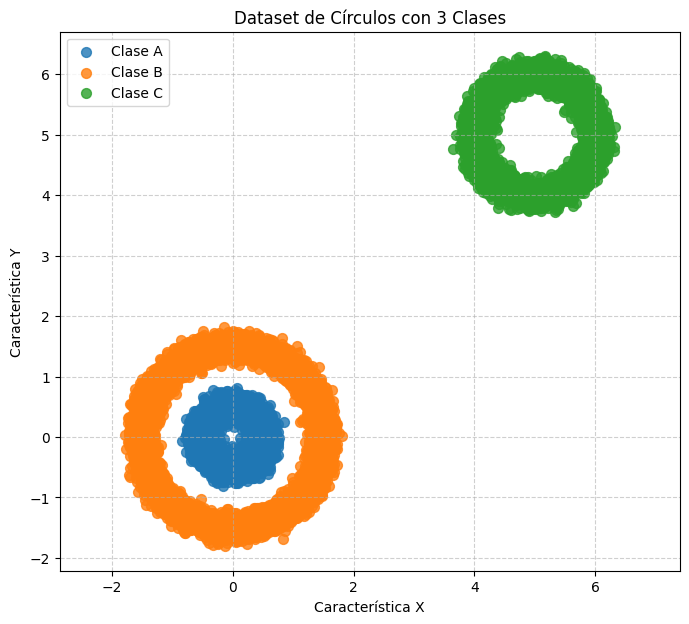

In [4]:
r1 = 0.5  
r2 = 1.5  
r3 = 1  

num_points = 10000
thetas = np.linspace(0, 2 * np.pi, num_points) 


x1 = r1 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y1 = r1 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


x2 = r2 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y2 = r2 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


x3 = 5 + r3 * np.cos(thetas) + 0.1 * np.random.randn(num_points)
y3 = 5 + r3 * np.sin(thetas) + 0.1 * np.random.randn(num_points)


plt.figure(figsize=(8, 7)) 


plt.scatter(x1, y1, s=50, label="Clase A", alpha=0.8) # Puntos de la Clase A
plt.scatter(x2, y2, s=50, label="Clase B", alpha=0.8) # Puntos de la Clase B
plt.scatter(x3, y3, s=50, label="Clase C", alpha=0.8) # Puntos de la Clase C

plt.xlabel("Característica X") 
plt.ylabel("Característica Y")
plt.title("Dataset de Círculos con 3 Clases")
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')
plt.show() 


In [5]:
df = pd.DataFrame(
    {"x": x1.tolist()+x2.tolist()+x3.tolist(),
    "y": y1.tolist()+y2.tolist()+y3.tolist(),
    "labels":['A' for _ in range(num_points)]+['B' for _ in range(num_points)]+['C' for _ in range(num_points)]
    })

labels = df["labels"].unique()
labels2id = {label: i for i, label in enumerate(labels)}
id2labels = {v: k for k, v in labels2id.items()}

df["labels"] = df["labels"].map(labels2id)
df.head()

,x,y,labels
0,0.646916,0.048420,0
1,0.526934,0.175179,0
2,0.595373,0.028089,0
3,0.542237,-0.010078,0
4,0.426221,-0.060961,0


In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)



if device == 'gpu':
    X_train = tensor(df_train[["x","y"]].values).to('gpu')
    Y_train = tensor(df_train[["labels"]].values).to('gpu')

    X_test = tensor(df_test[["x","y"]].values).to('gpu')
    Y_test = tensor(df_test[["labels"]].values).to('gpu')

else:
    X_train = tensor(df_train[["x","y"]].values)
    Y_train = tensor(df_train[["labels"]].values)

    X_test = tensor(df_test[["x","y"]].values)
    Y_test = tensor(df_test[["labels"]].values)

print(f"X_train shape: {X_train.shape}, device: {X_train.device}")
print(f"Y_train shape: {Y_train.shape}, device: {Y_train.device}")
print(f"X_test shape: {X_test.shape}, device: {X_test.device}")
print(f"Y_test shape: {Y_test.shape}, device: {Y_test.device}")


X_train shape: (24000, 2), device: gpu
Y_train shape: (24000, 1), device: gpu
X_test shape: (6000, 2), device: gpu
Y_test shape: (6000, 1), device: gpu


In [7]:
X_train.grad

In [8]:
class Network(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2, 4)
        self.relu = Relu()
        self.fc2 = Linear(4, 4)
        self.fc3 = Linear(4, 3)

    def forward(self, x: tensor) -> tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


net = Network().to(device)
net.parameters()

[Tensor(
 [[ 0.82184812  1.65849734 -0.21329843 -0.22710424]
  [-1.28396598  1.08825148 -0.06972136 -0.03704953]], shape=(2, 4), device=gpu, requires_grad=True),
 Tensor(
 [[0. 0. 0. 0.]], shape=(1, 4), device=gpu, requires_grad=True),
 Tensor(
 [[ 0.30648765  0.21343028 -0.09919398  0.93407362]
  [-1.13397806  0.14940732  0.28791216 -0.29160606]
  [ 0.43589576  0.46887451  0.78475726 -0.0788846 ]
  [-0.15354739  0.38126807 -0.13964173 -1.07575263]], shape=(4, 4), device=gpu, requires_grad=True),
 Tensor(
 [[0. 0. 0. 0.]], shape=(1, 4), device=gpu, requires_grad=True),
 Tensor(
 [[ 0.60982541 -1.29703549  0.28402848]
  [ 1.79498594  0.37703977 -0.49080712]
  [-0.31916267  0.26207058 -0.01511212]
  [ 0.53475129  1.02536398  0.9294297 ]], shape=(4, 3), device=gpu, requires_grad=True),
 Tensor(
 [[0. 0. 0.]], shape=(1, 3), device=gpu, requires_grad=True)]

In [9]:
criterion = CrossEntropyLoss()
optimizer = RMSprop(net.parameters(), lr=1e-2)

In [10]:
out = net(X_train)
out

Tensor(
[[ 0.15693801  0.11731706 -0.06915253]
 [ 2.63201368  1.96752914 -1.15975994]
 [ 2.38313791  1.78148515 -1.05009632]
 ...
 [ 2.18070756  1.63016085 -0.96089823]
 [ 2.18985413  1.63699826 -0.96492853]
 [ 0.59424182  0.46091001  0.11742706]], shape=(24000, 3), device=gpu, requires_grad=True)

# Training

In [11]:
# Bucle de entrenamiento mejorado
for epoch in range(10000 + 1):
    out = net(X_train)
    loss = criterion(Y_train, out)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        acc_train = (out.data.argmax(axis=1, keepdims=True) == Y_train.data).mean()
        with allison.no_grad():
            out = net(X_test)
            acc_test = (out.data.argmax(axis=1, keepdims=True) == Y_test.data).mean()

        # Usamos una f-string para formatear y alinear la salida
        print(f"[{device}] Epoch {epoch:5d} | Loss: {loss.data:.4f} | Acc Train: {acc_train*100:.2f}% | Acc Test: {acc_test*100:.2f}%")

        if acc_test >= 0.98:  # Mejoramos el criterio de parada
            print(f"Entrenamiento completado en {epoch} epochs!")
            break


[gpu] Epoch     0 | Loss: 2.0356 | Acc Train: 33.59% | Acc Test: 21.38%
[gpu] Epoch   100 | Loss: 0.1292 | Acc Train: 98.92% | Acc Test: 98.95%
Entrenamiento completado en 100 epochs!


# Prediction

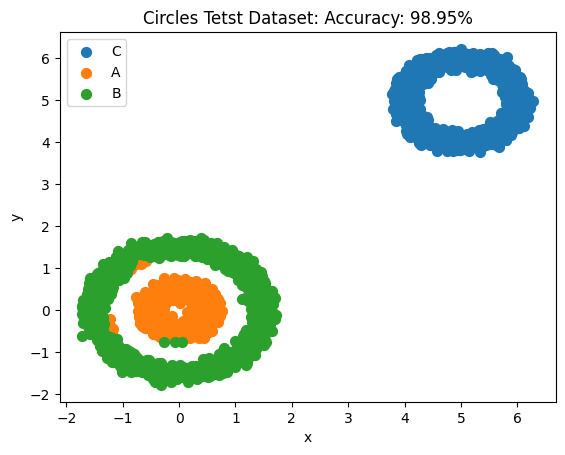

In [12]:
with allison.no_grad():
    out = net(X_test)

y_pred = out.data.argmax(axis=1,keepdims=True)
acc = (y_pred == Y_test.data).mean()    

if device == "gpu":
    y_pred = y_pred.get().flatten()
else:
    y_pred = y_pred.flatten()

y_pred_labels = [id2labels[y] for y in y_pred]

df_test['pred_labels'] = y_pred_labels

for label in df_test['pred_labels'].unique():
    x = df_test[df_test['pred_labels'] == label]['x']
    y = df_test[df_test['pred_labels'] == label]['y']

    plt.scatter(x,y,s=50,label=label)

plt.title(f"Circles Tetst Dataset: Accuracy: {100*acc:.2f}%")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

<Axes: >

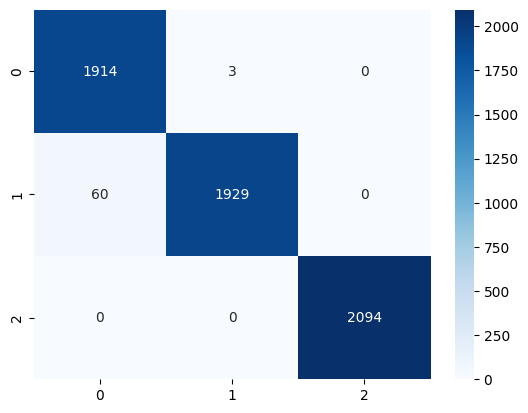

In [13]:
if device == "gpu":
    y_real = Y_test.data.flatten().get()
else:
    y_real = Y_test.data.flatten()

sns.heatmap(confusion_matrix(y_real, y_pred), annot=True, cmap="Blues", fmt=".0f")

In [14]:
print(classification_report(y_real, y_pred))

            precision   recall f1-score  support
0                0.97     1.00     0.98     1917
1                1.00     0.97     0.98     1989
2                1.00     1.00     1.00     2094

accuracy                           0.99     6000
macro avg        0.99     0.99     0.99     6000
weighted avg     0.99     0.99     0.99     6000


# Save and Load Model

In [15]:
import joblib

In [16]:
joblib.dump(net.weights(), "model_weights.joblib")

['model_weights.joblib']

# CPU

In [17]:
net2 = Network()
net2.load_weights(joblib.load('model_weights.joblib'))

if X_test.device == 'cpu':
    with allison.no_grad():
        out = net2(X_test)
if X_test.device == 'gpu':
    with allison.no_grad():
        out = net2(X_test.to('cpu'))

out

Tensor(
[[-21.67077291   5.7049438   10.77535453]
 [-24.37094943   6.92107026  12.61758069]
 [-21.32683669   5.91472683  10.78981473]
 ...
 [  4.46427391   2.37446883  -3.09383398]
 [  1.42302084   3.13505198  -1.20265087]
 [-27.54125212   8.34969035  14.53027001]], shape=(6000, 3), device=cpu, requires_grad=False)

# GPU

In [18]:
net2 = Network()
net2.load_weights(joblib.load('model_weights.joblib'))
net2.to('gpu')

if X_test.device == 'cpu':
    with allison.no_grad():
        out = net2(X_test.to('gpu'))
if X_test.device == 'gpu':
    with allison.no_grad():
        out = net2(X_test)

out

Tensor(
[[-21.67077291   5.7049438   10.77535453]
 [-24.37094943   6.92107026  12.61758069]
 [-21.32683669   5.91472683  10.78981473]
 ...
 [  4.46427391   2.37446883  -3.09383398]
 [  1.42302084   3.13505198  -1.20265087]
 [-27.54125212   8.34969035  14.53027001]], shape=(6000, 3), device=gpu, requires_grad=False)